## Undamped Displacement and Energy Analysis

The following plot represents the initial condition and boundary conditions of the problem, or the movement of the string if it were to be plucked at its center with specified limits. The plucking motion will be assumed to produce no initial velocity, however, there will be an initial displacement. To analyze this initial displacement, we begin by setting up the physical and numerical parameters for the undamped vibrating string.

The governing equation we will be using is the wave equation without damping:

$$
u_{tt}(x, t) = c^2 u_{xx}(x, t)
$$

Before graphing, we must set up our intial parameters: 
1. The string is 1 meter long: $ L = 1.0 $
2. The wave speed is $ c = 100.0 \ \frac{m}{s} $
3. The string is clamped at both ends: $ u(0, t) = u(L, t) = 0 $
4. The string is plucked in the middle, producing a smooth initial displacement
5. The initial velocity is zero: $ u_t(x, 0) = 0 $

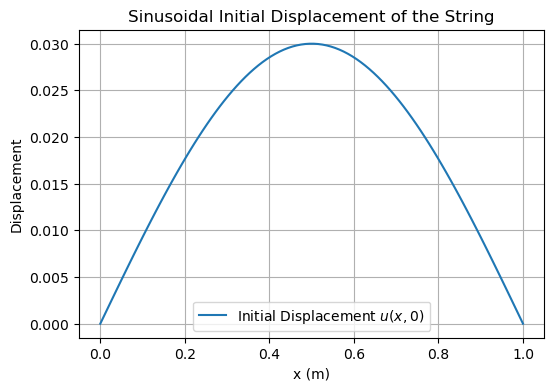

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Physical parameters
L = 1.0                # Length of the string (meters)
c = 100.0              # Wave speed (m/s)
gamma = 0.0            # No damping for undamped case

# Numerical parameters
N = 100                # Number of spatial points
x = np.linspace(0, L, N)
dx = x[1] - x[0]       # Spatial step size

# Initial displacement: smooth pluck using the first sine mode
u0 = 0.03*np.sin(np.pi * x / L)
u0[0] = u0[-1] = 0  # Enforce Dirichlet BCs explicitly

# Initial velocity is zero everywhere
v0 = np.zeros_like(x)

# Plot initial condition
plt.figure(figsize=(6, 4))
plt.plot(x, u0, label="Initial Displacement $u(x, 0)$")
plt.title("Sinusoidal Initial Displacement of the String")
plt.xlabel("x (m)")
plt.ylabel("Displacement")
plt.grid(True)
plt.legend()
plt.show()

## Displacement Over-Time using Newmark-Beta

We now solve the second-order ODE system resulting from the spatial discretization:

$$
\frac{d^2 \mathbf{u}}{dt^2} = \mathbf{D2} \cdot \mathbf{u}
$$

We use the Newmark-beta method with parameters $\beta = \frac{1}{4}$ and $\gamma = \frac{1}{2}$. This scheme is unconditionally stable for linear problems and second-order accurate in time. The update formulas for the displacement $\mathbf{u}^{n+1}$ and velocity $\mathbf{v}^{n+1}$ are:

$
\begin{aligned}
\mathbf{u}^{n+1} &= \mathbf{u}^n + \Delta t\, \mathbf{v}^n + \frac{\Delta t^2}{2} \left( (1 - 2\beta) \mathbf{a}^n + 2\beta \mathbf{a}^{n+1} \right) \\
\mathbf{v}^{n+1} &= \mathbf{v}^n + \Delta t \left( (1 - \gamma) \mathbf{a}^n + \gamma \mathbf{a}^{n+1} \right)
\end{aligned}
$

To solve for $\mathbf{u}^{n+1}$, we rearrange terms into a linear system at each time step. Because $\mathbf{D2}$ is constant and sparse, this is efficient to do.

We will now implement this scheme and evolve the solution in time. The solution is consistent with how a guitar string looks when plucked. Notice that the string's movement is not lessening over time due to the lack of resistance to its motion. 

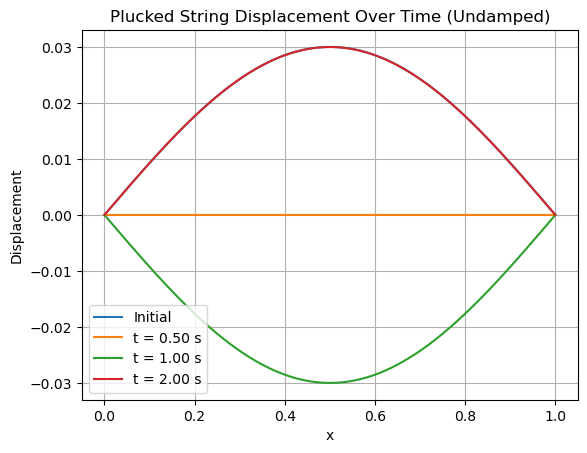

In [25]:
# Newmark-beta parameters
beta = 1/4
gamma = 1/2

# Time discretization
T = 2.0                   # Total simulation time (s)
dt = 0.00025                # Time step (s)
Nt = int(T / dt)          # Number of time steps
time = np.linspace(0, T, Nt+1)

# Initialize solution arrays
u = np.zeros((Nt+1, n+2))  # displacement
v = np.zeros((Nt+1, n+2))  # velocity
a = np.zeros((Nt+1, n+2))  # acceleration

# Initial conditions
u[0, :] = u0
v[0, :] = v0
a[0, :] = D2 @ u0          # initial acceleration

# Precompute effective mass matrix (identity) and factor
I = np.eye(n+2)
A_eff = I - beta * dt**2 * D2

# Time stepping loop
for k in range(Nt):
    rhs = u[k] + dt * v[k] + 0.5 * dt**2 * a[k]
    u[k+1] = np.linalg.solve(A_eff, rhs)
    a[k+1] = D2 @ u[k+1]
    v[k+1] = v[k] + 0.5 * dt * (a[k] + a[k+1])

# Plot solution at final time
plt.plot(x, u[0], label='Initial')
plt.plot(x, u[Nt//4], label=f't = {time[Nt//4]:.2f} s')
plt.plot(x, u[Nt//2], label=f't = {time[Nt//2]:.2f} s')
plt.plot(x, u[-1], label=f't = {time[-1]:.2f} s')
plt.xlabel('x')
plt.ylabel('Displacement')
plt.title('Plucked String Displacement Over Time (Undamped)')
plt.legend()
plt.grid(True)
plt.show()

## Plotting Total Mechanical Energy over Time

On the following graph, the total energy of the undamped string over time is shown. We can assume that the guitar string's energy emitted from the pluck is the sum of:

- Kinetic Energy: Approximated using the discrete squared velocity values.
- Potential Energy: Approximated using the squared gradient of the displacement.

The energy functions appear in integral notation and are approximated using the midpoint rule across the spatial grid. Since the system is undamped, the total energy should remain constant, confirming conservation of energy. If you take a look at the graph you will notice slight change that is relevant to the numerical method error. 

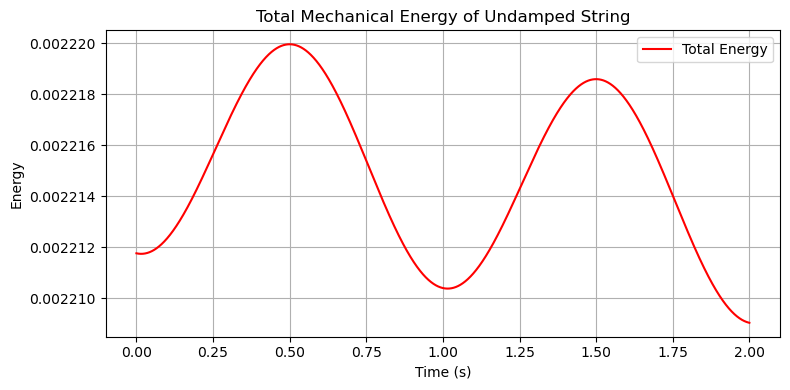

In [26]:
# Compute energy over time
energy = np.zeros(Nt+1)

for k in range(Nt+1):
    # Kinetic energy
    KE = 0.5 * np.sum(v[k, 1:-1]**2) * dx

    # Approximate ∂u/∂x using central difference
    du_dx = (u[k, 2:] - u[k, :-2]) / (2 * dx)

    # Potential energy
    PE = 0.5 * np.sum(du_dx**2) * dx

    # Total energy
    energy[k] = KE + PE

# Plot energy
plt.figure(figsize=(8, 4))
plt.plot(time, energy, label='Total Energy', color='red')
plt.xlabel('Time (s)')
plt.ylabel('Energy')
plt.title('Total Mechanical Energy of Undamped String')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()